In [22]:
import pandas as pd
import numpy as np
from numpy import array, median, sqrt
from hw import Jamshidian as jamsh
from hw import Henrard as henr
from hw import hw_helper
from hw import calibration as hw_calib
from hw.const import *
from fox_toolbox.utils import xml_parser, rates
from random import choice
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import seaborn as sns
# sns.set_context("poster")
# sns.set(rc={'figure.figsize': (25, 15)})
# sns.set_style("whitegrid")

from pylab import rcParams
rcParams['figure.figsize'] = 8, 15

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

mpl.rc('font', **font)

np.set_printoptions(precision=2)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read IRSM FORM

In [2]:
irsmform, irsmout = [xml_parser.get_files(regex) for regex in ['irsmform', 'irsmout']]

debug_df = pd.DataFrame()

In [3]:
main_curve, sprds = xml_parser.get_rate_curves(irsmform)
dsc_curve = main_curve

try:
    estim_curve = sprds[0]
except TypeError:
    estim_curve = main_curve

cal_basket = list(xml_parser.get_calib_basket(irsmform))
mr = xml_parser.get_hw_params(irsmform).meanR

### READ IRSM OUT

In [4]:
ref_swos = list(xml_parser.get_calib_basket(irsmout))
ref_mr = mr

In [5]:
ref_sigmas = xml_parser.get_hw_params(irsmout).hw_volatility

## Hernard pricer with its ref sigma

In [6]:
calib_premiumsH = []


for swo in cal_basket:

    henr_price, debug = henr.hw_swo(swo, ref_mr, ref_sigmas, dsc_curve, estim_curve)
    debug_df = pd.concat([debug_df, pd.DataFrame(data=debug)], sort=False)
    calib_premiumsH.append(henr_price)

calib_premiumsH

[0.0017855237853967032,
 0.0022953529814707108,
 0.002448987695905236,
 0.002404157885418312,
 0.002034635028439813,
 0.0015233239456680647,
 0.0008166148217094715]

## HW Calibration

In [7]:
sigma_hw_henr, debug_H = hw_calib.calibrate_sigma_hw(cal_basket, ref_mr, dsc_curve, estim_curve, IsJamsh=False)
sigma_hw_henr

Starting calibration on 7 swaptions with vol type: SLN
 at T=0.2493150684932 vol=0.005288872277806995
 at T=0.5013698630137 vol=0.0059095004843945425
 at T=0.7534246575342 vol=0.006360394758650601
 at T=1.0027397260274 vol=0.007246466555520291
 at T=1.2493150684932 vol=0.006454143106672785
 at T=1.5013698630137 vol=0.0071343222727166524
 at T=1.7534246575342 vol=0.007298925266742018


Curve(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75, 31.75]), array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), 'PieceWise', 'HW model sigma Henrard')

c:\users\mkapchenko\appdata\local\programs\python\python37\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


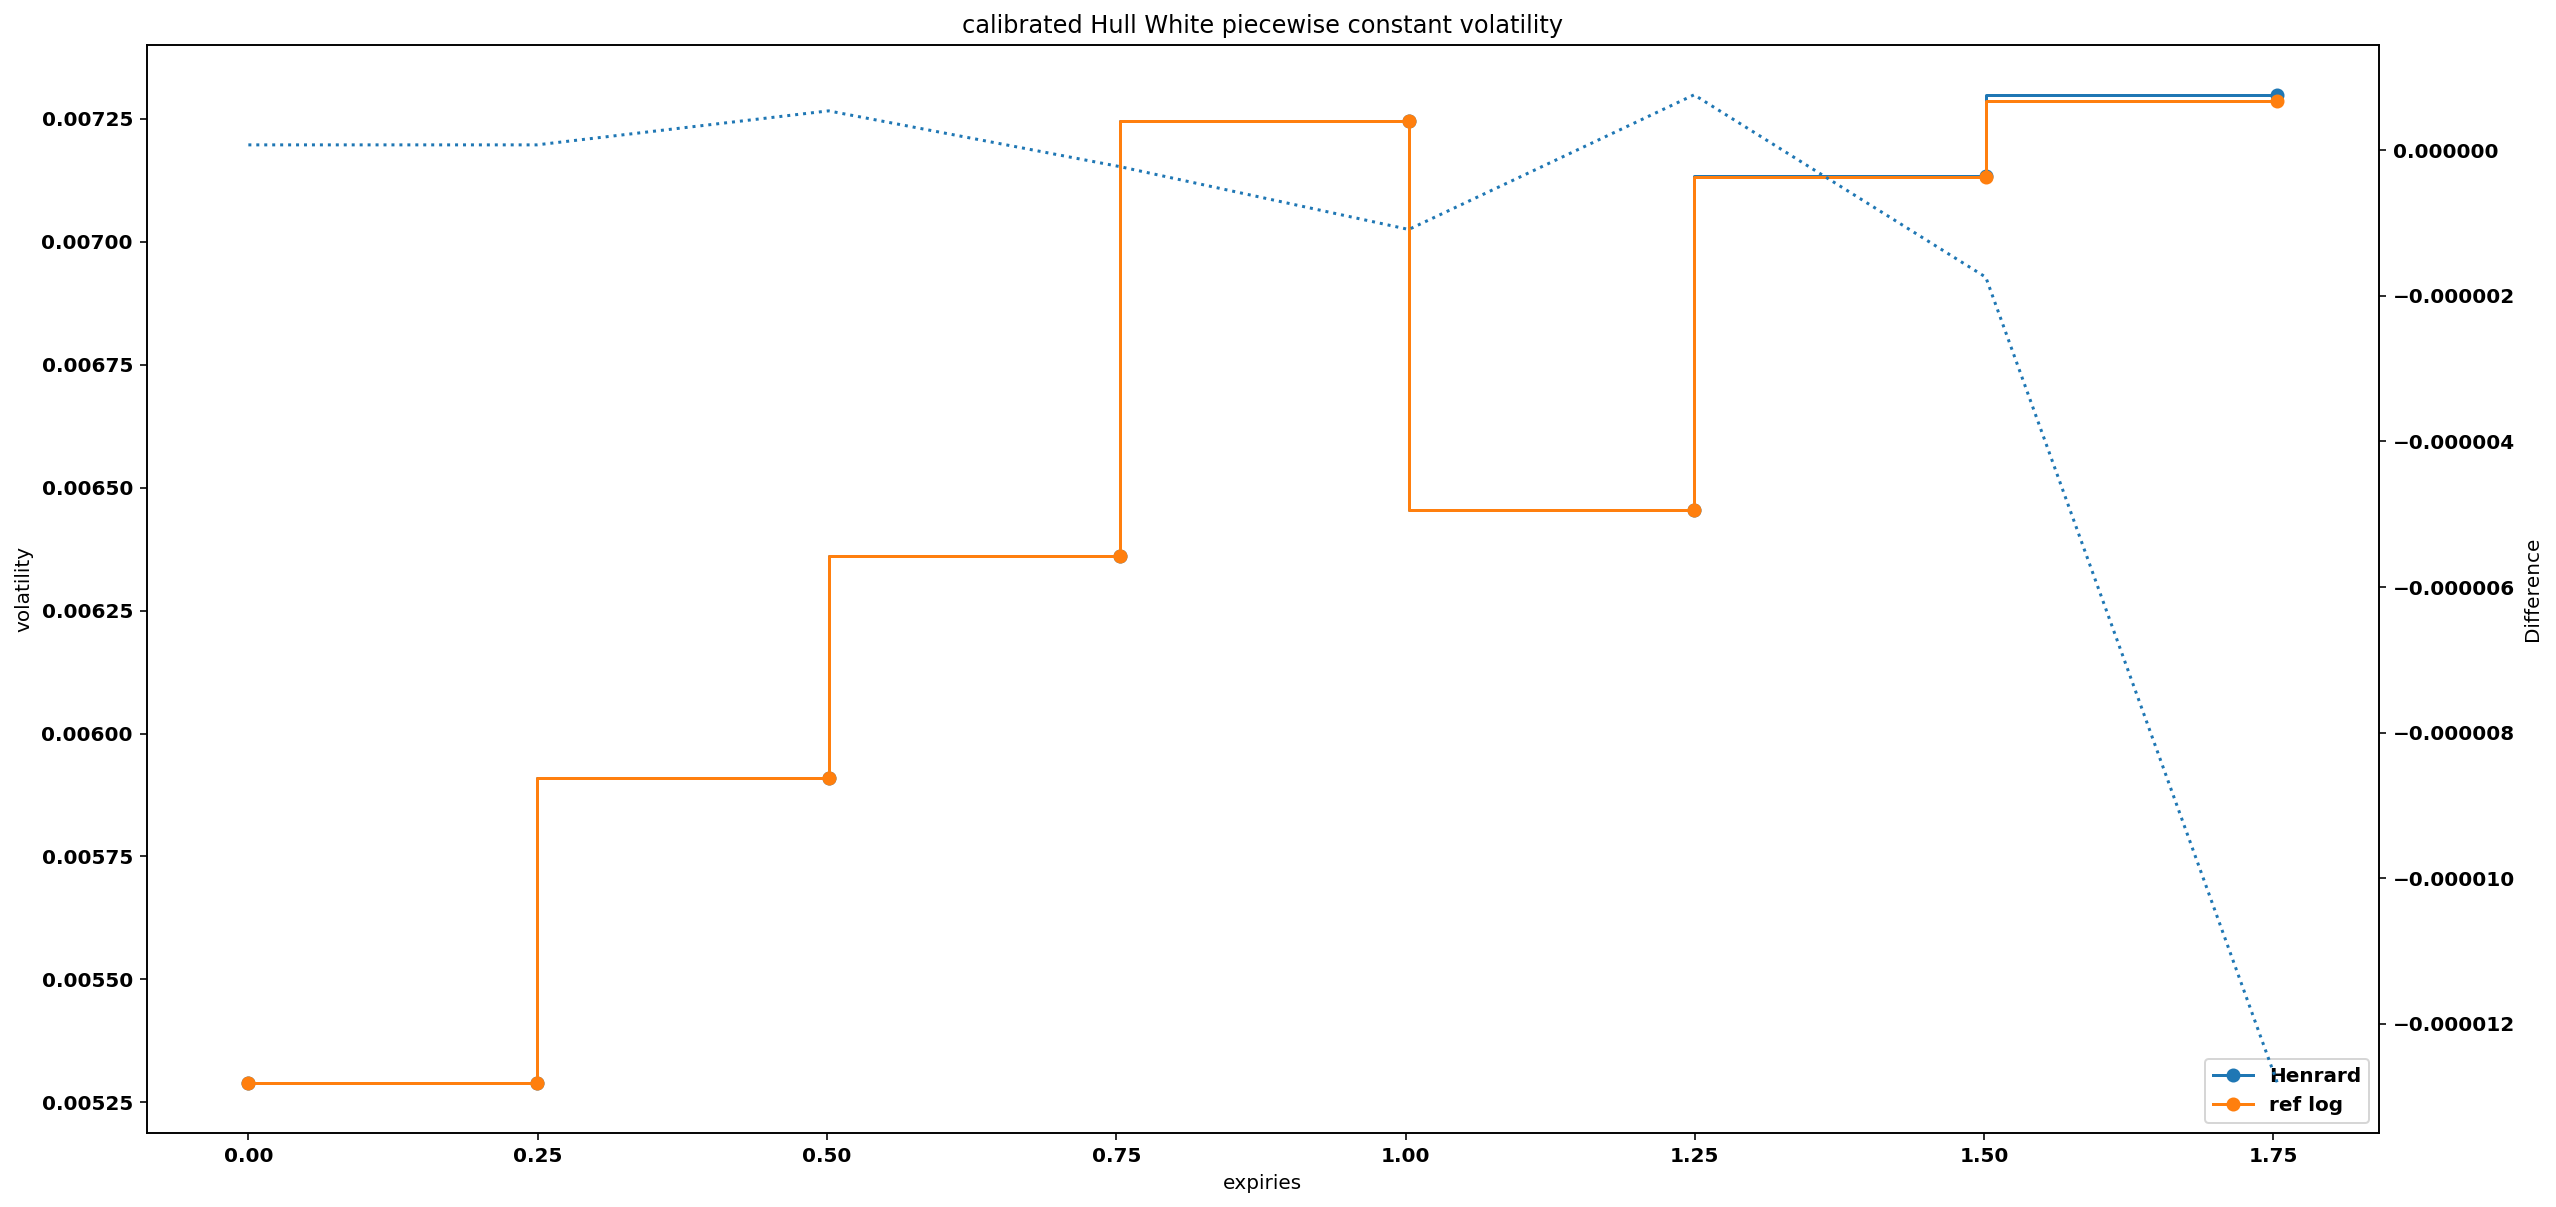

In [8]:
plt.figure(figsize=(20,10))

plt.step(sigma_hw_henr.buckets[:-1],   sigma_hw_henr.values[:-1],   label = 'Henrard', marker='o', where='pre')
plt.step(ref_sigmas.buckets[:-1], ref_sigmas.values[:-1], label = 'ref log', marker='o', where='pre')

plt.legend(loc='lower right')
plt.title('calibrated Hull White piecewise constant volatility')
plt.xlabel('expiries')
plt.ylabel('volatility')

ax = plt.twinx()  # instantiate a second axes that shares the same x-axis
ax.plot(sigma_hw_henr.buckets[:-1], ref_sigmas.values[:-1] - sigma_hw_henr.values[:-1], ls=':')
ax.set_ylabel('Difference');

In [9]:
pricesH = []
for swo in cal_basket:
    henr_price, debug = henr.hw_swo(swo, ref_mr, sigma_hw_henr, dsc_curve, estim_curve)
    pricesH.append(henr_price)

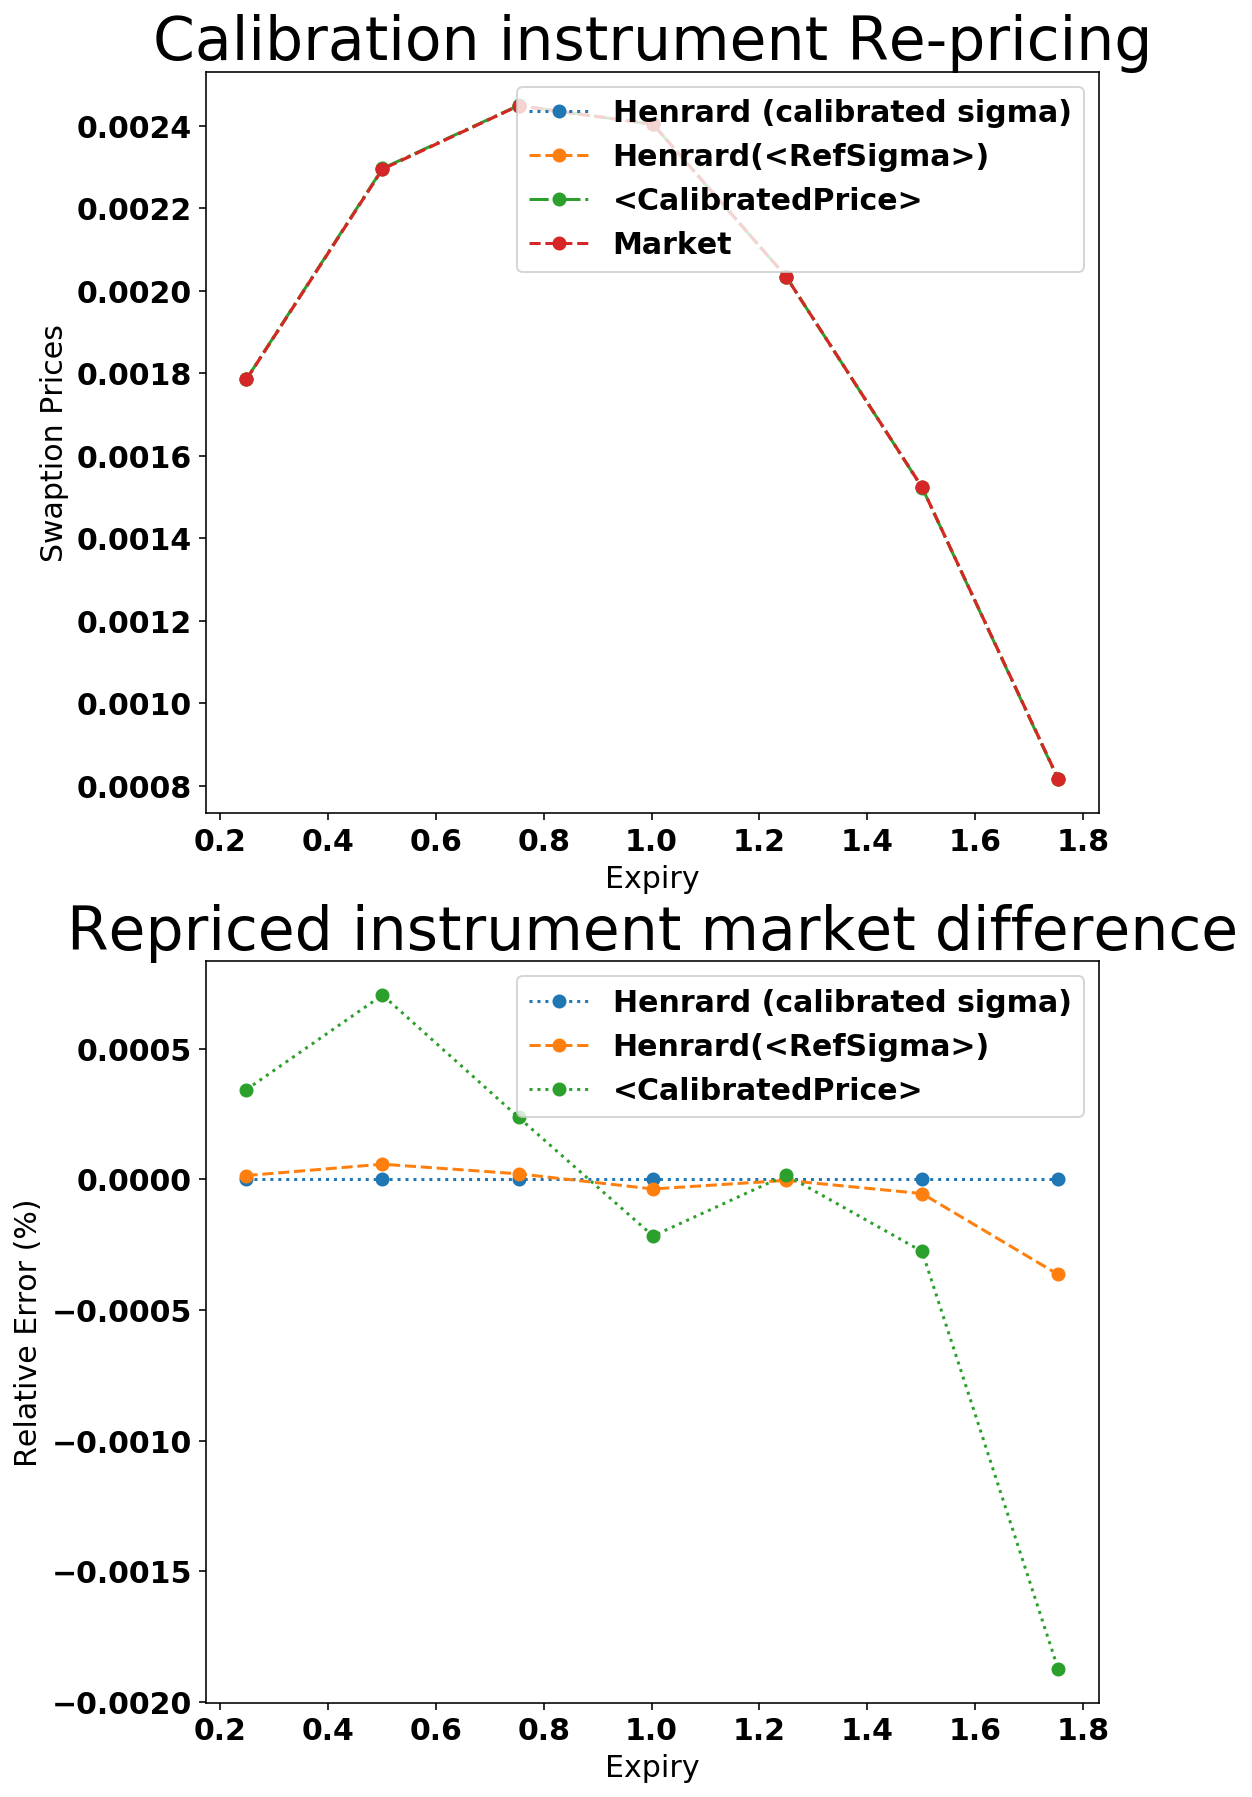

In [26]:
ref_calib_prices = [ref_swo.cal_premium for ref_swo in ref_swos]
black_prices = pd.DataFrame(data=debug_H).target_price

prices_dict = {
               
               'Henrard (calibrated sigma)':array(pricesH),
               'Henrard(<RefSigma>)': array(calib_premiumsH),
               
               '<CalibratedPrice>': array(ref_calib_prices),        
               'Market': array(black_prices)
              }

plt.subplot(2,1,1)
for lbl, prices in prices_dict.items():
    plt.plot([swo.expiry for swo in cal_basket], prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');
    
plt.title('Calibration instrument Re-pricing', fontsize= 30);
plt.xlabel('Expiry')
plt.ylabel('Swaption Prices')
plt.legend(loc='upper right');

plt.subplot(2,1,2)
for lbl, prices in list(prices_dict.items())[:-1]:
    plt.plot([swo.expiry for swo in cal_basket], (prices - black_prices)/black_prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');

plt.title('Repriced instrument market difference' , fontsize= 30);
plt.xlabel('Expiry')
plt.ylabel('Relative Error (%)')
plt.legend(loc='upper right');

In [11]:
swo1 = cal_basket[-1]
swo1.get_swap_rate(dsc_curve, estim_curve)

0.014259425528404628

In [31]:
swo.payment_dates

array([0.26, 0.52, 0.77, 1.02, 1.27, 1.52, 1.77, 2.01])

In [35]:
swo.asdict()

{'_dcfs': array([0.01, 0.26, 0.26, 0.25, 0.25, 0.25, 0.26, 0.25]),
 '_expiry': 0.2493150684932,
 '_libor_tenor': 3,
 '_pmnt_dates': array([0.26, 0.52, 0.77, 1.02, 1.27, 1.52, 1.77, 2.01]),
 '_start_date': 0.2547945205479,
 '_vol': Volatility(value=0.3305, type='SLN', shift_size=0.0),
 'annuity': nan,
 'cal_premium': 0.0,
 'cal_type': 'ATM',
 'cal_vol': 0.0,
 'fwd': nan,
 'fwdAdj': nan,
 'fwdAdjModel': nan,
 'lvl': 0,
 'pay_rec': 'Receiver',
 'strike': 0.015556294390843,
 'tgt_premium': nan}

In [36]:
swo.start_date

0.2547945205479